In [1]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm 
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torchinfo

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [3]:
def split_train_test_val(data, target, test_size, val_size):
    nb_samples = len(target)
    nb_test = int(test_size * nb_samples)
    nb_val = int(val_size * nb_samples)

    shuffle = list(range(nb_samples))
    random.shuffle(shuffle)

    x_train, x_test, x_val, y_train, y_test, y_val = [], [], [], [], [], []
    
    nb_0_test = 0
    nb_1_test = 0
    nb_0_val = 0
    nb_1_val = 0

    for idx in shuffle:
        if nb_0_test < (nb_test//2) and target[idx]==0:
            y_test.append(0)
            x_test.append(data[idx])
            nb_0_test += 1
        elif nb_1_test < (nb_test//2) and target[idx]==1:
            y_test.append(1)
            x_test.append(data[idx])
            nb_1_test += 1
        elif nb_0_val < (nb_val//2) and target[idx]==0:
            y_val.append(0)
            x_val.append(data[idx])
            nb_0_val += 1
        elif nb_1_val < (nb_val//2) and target[idx]==1:
            y_val.append(1)
            x_val.append(data[idx])
            nb_1_val += 1
        else:
            y_train.append(target[idx])
            x_train.append(data[idx])
    
    return x_train, x_test, x_val, y_train, y_test, y_val


def prepareData(dataGroup, id_list, window_time):
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
    elif dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):
        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")

        # 0 --> HR
        # 1 --> SpO2
        # 2 --> PAD
        # 3 --> PAM
        # 4 --> PAS
        # 5 --> RR
        # 6 --> Temperature
        # 7 --> Diuresis
        # 8 --> SpO2/FiO2
        # 9 --> FiO2
        # 10 --> ECMO flow
        
        # idx_variables_kept = [0,1,3,4,6,7]
        if dataGroup == "dataECMO":
            # idx_variables_kept = [0,1,2,3,4,5,6,7,8,9]
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]
        else:
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]

        data_patient = df_dynamic.iloc[:(window_time*24), idx_variables_kept].to_numpy()
        
        for value in df_static.to_numpy()[0]:
            new_column = np.ones(shape=(window_time*24,1)) * value
            data_patient = np.append(data_patient, new_column, axis=1)
        
        # df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)

        # # idx_variables_kept = [0,1,3,4,6,7]
        # idx_variables_kept = list(range(0,10))
        # df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        # df_dynamic = df_dynamic.iloc[:,idx_variables_kept]


        data.append(data_patient)
    
    return np.array(data)


def prepareDeathList(dataGroup, window_time):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        patients_df = pd.read_csv(dataPath + "ventiles.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])

            df_mask = pd.read_parquet(dataPath + "finalData/" + stay_id + "/mask.parquet")
            total_true_values = df_mask.values.sum()
            total_values = df_mask.values.size
            percentageMissingValues = (total_values-total_true_values)/total_values * 100

            if percentageMissingValues < 40:
                id_list.append(stay_id)
                
                label_death = int(row["label"])
                target.append(label_death)
            
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    elif dataGroup == "dataRangueil":
        dataPath = "../dataRea/"

    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            id_list.append(encounterId)
            
            delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
            if delai_sortie_deces <= 1:
                target.append(1)
            else:
                target.append(0)
    
    return target, id_list

In [4]:
target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO = prepareData("dataECMO", id_list_ECMO, window_time=5)

print(f"ECMO dataset size: {len(target_ECMO)} , num_deceased: {np.sum(target_ECMO)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 166.14it/s]

ECMO dataset size: 153 , num_deceased: 55


In [5]:
target_Rangueil, id_list_Rangueil =  prepareDeathList("dataRangueil", window_time=5)
data_Rangueil = prepareData("dataRangueil", id_list_Rangueil, window_time=5)

print(f"Rea dataset size: {len(target_Rangueil)} , num_deceased: {np.sum(target_Rangueil)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1697/1697 [00:10<00:00, 164.25it/s]


Rea dataset size: 1697 , num_deceased: 445


In [6]:
target_Mimic, id_list_Mimic = prepareDeathList("dataMimic", window_time=5)
data_Mimic = prepareData("dataMimic", id_list_Mimic, window_time=5)

print(f"Mimic dataset size: {len(target_Mimic)} , num_deceased: {np.sum(target_Mimic)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4140/4140 [00:25<00:00, 164.66it/s]

Mimic dataset size: 4140 , num_deceased: 1049


In [7]:
target_MR = target_Mimic + target_Rangueil
id_list = id_list_Mimic + id_list_Rangueil

data_MR = np.concatenate((data_Mimic,data_Rangueil),axis=0)

print(f"dataset size mimic+rea: {len(target_MR)} , num_deceased: {np.sum(target_MR)}")

dataset size mimic+rea: 5837 , num_deceased: 1494


In [8]:
class CNN_1D_0(nn.Module):
    def __init__(self, num_features, num_static_features):
        super(CNN_1D_0, self).__init__()
        
        self.num_features = num_features
        self.num_static_features = num_static_features

        self.conv1 = nn.Conv1d(in_channels=num_features-num_static_features, out_channels=8, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(480 , 4)
        self.fc2 = nn.Linear(4+num_static_features, 1)  

        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        cnn_input = x[:, :-self.num_static_features, :]
        static_input = x[:, -self.num_static_features:, 0]

        out = self.pool(nn.functional.relu(self.conv1(cnn_input)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = torch.cat((out, static_input), dim=1)
        # out = self.dropout1(out)
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))  
        return out
    
class CNN_1D_1(nn.Module):
    def __init__(self, num_features):
        super(CNN_1D_1, self).__init__()
        
        self.num_features = num_features

        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=8, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(480 , 32)
        self.fc2 = nn.Linear(32, 1)  

    def forward(self, x):

        out = self.pool(nn.functional.relu(self.conv1(x)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))  
        return out
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 3), padding=1)
        
        self.fc1 = nn.Linear(2976, 4) 
        self.fc2 = nn.Linear(4, 1)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.75)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        # x = nn.functional.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_static_features):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_static_features = num_static_features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size + num_static_features, 20)
        # self.fc2 = nn.Linear(20, output_size)
        self.fc2 = nn.Linear(hidden_size + num_static_features, 1)
    
    def forward(self, x):
        lstm_input = x[:, :, :-self.num_static_features]
        static_input = x[:, 0, -self.num_static_features:]

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(lstm_input, (h0, c0))
        out = out[:, -1, :]  # Take the output of the last time step

        out = torch.cat((out, static_input), dim=1)
        # out = torch.relu(self.fc1(out))

        # out = nn.functional.sigmoid(self.fc2(out))
        out = self.fc2(out)
        return out

class LSTMModel2(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static):
        
        super(LSTMModel2, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_features_dynamic = num_features_dynamic
        self.num_features_static = num_features_static
        
        # Create a list of LSTM layers, one for each feature
        self.lstms = nn.ModuleList([nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) for _ in range(num_features_dynamic)])
        
        # Linear layer for binary classification
        self.fc = nn.Linear(hidden_size*num_features_dynamic + num_features_static, output_size)
        
    def forward(self, x):
        
        lstm_outputs = []

        for i in range(self.num_features_dynamic):
            feature_input = x[:, :, i].unsqueeze(2)  # Shape: (batch_size, seq_length, 1)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            lstm_out, _ = self.lstms[i](feature_input, (h0, c0))
            lstm_out = lstm_out[:, -1, :]  # Get the last time step output: Shape: (batch_size, hidden_size)
            lstm_outputs.append(lstm_out)
        
        # Concatenate the outputs from each LSTM
        out = torch.cat(lstm_outputs, dim=1)  # Shape: (batch_size, hidden_size * num_features)
        
        static_input = x[:, 0, -self.num_features_static:]
        out = torch.cat((out, static_input), dim=1)
        
        out = self.fc(out)
        # out = nn.functional.sigmoid(self.fc(out))  # Shape: (batch_size, output_size)
        
        return out

In [26]:
def train_model(data, target, test_fold, validation_activated, test_activated, num_epochs, model_name, verbose, save_path, save_model, plot_train_curves, load_model_path=None):
    
    # x_train, x_test, x_val, y_train, y_test, y_val = split_train_test_val(data, target, test_size=test_size, val_size=val_size)
    # if test_size > 0:
    #     x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
    #     while np.sum(y_test) < 2:
    #         x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size)

    #     if val_size > 0:
    #         x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
    #         while np.sum(y_val) == 0:
    #             x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
    #     else:
    #         x_val = np.array([])
    #         y_val = np.array([])
    # else:
    #     x_test = np.array([])
    #     y_test = np.array([])
    #     x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=val_size)
    #     while np.sum(y_val) < 2:
    #         x_train, x_val, y_train, y_val = train_test_split(data, target, test_size=val_size)
    
    num_samples = len(target)
    K = 10
    sub_samples_size = num_samples//K
    
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,9)
        while val_fold == test_fold:
            val_fold = random.randint(0,9)
    else:
        val_fold = None
    
    x_train = np.empty((0,np.shape(data)[1], np.shape(data)[2]))
    y_train = []
    x_test = []
    y_test = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            x_train = np.concatenate((x_train, current_data_fold))
            y_train = y_train + current_target_fold

    
    num_timesteps = np.size(x_train,1)
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static

    
    batch_size = 32

    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)


    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    if model_name == "CNN_1D_0":
        model = CNN_1D_0(num_features=num_features, num_static_features=num_features_static)

        # if verbose:
        #     print(torchinfo.summary(model, input_size=(batch_size, num_features, num_timesteps)))
    
    if model_name == "CNN_1D_1":
        model = CNN_1D_1(num_features=num_features)

    elif model_name == "CNN2":
            model = CNN2()

            if verbose:
                print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    elif model_name == "LSTM":
        input_size = num_features-num_features_static
        hidden_size = 32
        num_layers = 2
        output_size = 1

        model = LSTMModel(input_size, hidden_size, num_layers, output_size, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    if model_name == "LSTM2":
        input_size = 1
        hidden_size = 8
        num_layers = 1
        output_size = 1

        model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    if load_model_path != None:
        state_dict = torch.load(load_model_path)
        model.load_state_dict(state_dict)

    # criterion = nn.BCELoss()  # Binary cross-entropy loss

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    optimizer = optim.Adam(model.parameters())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_auroc = 0
    best_model_state = None
    val_auroc_list = []
    train_auroc_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        predictions = []
        true_labels = []
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            prediction = nn.functional.sigmoid(outputs).detach()
            predictions.extend(prediction.cpu().numpy())
            
            true_labels.extend(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_auroc = roc_auc_score(true_labels, predictions)
        train_auroc_list.append(train_auroc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Train AUROC: {train_auroc:.4f}")

        # Validation
        if validation_activated:
            model.eval()
            val_loss = 0.0

            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.permute(0, 2, 1)

                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

                    prediction = nn.functional.sigmoid(outputs)
                    predictions.extend(prediction.cpu().numpy())

                    true_labels.extend(labels.cpu().numpy())
                    
        
            val_auroc = roc_auc_score(true_labels, predictions)
            val_auroc_list.append(val_auroc) 
            if verbose:
                print(f"Validation Loss: {val_loss:.4f}, Validation AUROC: {val_auroc:.4f}")

            if val_auroc > best_val_auroc and val_auroc < train_auroc:
                best_val_auroc = val_auroc
                best_model_state = model.state_dict()
                torch.save(model.state_dict(), save_path)
            

    if validation_activated:
        if best_val_auroc > 0:
            state_dict = torch.load(save_path)
            model.load_state_dict(state_dict)

        if plot_train_curves:
            plt.figure(figsize=(10, 6))

            plt.plot(range(num_epochs), train_auroc_list, label='Train AUROC', color='blue')
            plt.plot(range(num_epochs), val_auroc_list, label='Validation AUROC', color='red')

            plt.xlabel('epochs')
            plt.ylabel('auroc')
            plt.title('Train and Val AUROC = f(epoch)')

            plt.legend()

            plt.show()

    if test_activated:
        model.eval()
    
        auroc, precision, recall, tnr, f1, accuracy = 0,0,0,0,0,0 
    
        true_labels = []
        predictions = []
        predictions_binary = []
    
        treshold = 0.5
    
        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        with torch.no_grad():
            for inputs, labels in test_loader:
    
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1)
                
                true_labels.extend(labels.cpu().numpy())
    
                outputs = nn.functional.sigmoid(model(inputs)).cpu().numpy()
                predictions.extend(outputs)
                predictions_binary.extend((outputs > treshold).astype(int))
    
                for k in range(len(outputs)):
                    pred = outputs[k][0]
                    group = int(pred * 10)
                    group = min(group,9)
                    HL_num_groups[group] +=1
                    HL_pred_groups[group] += pred
                    if labels[k] > 0.5:
                        HL_true_groups[group] += 1
                # print(HL_pred_groups)
                # print(HL_num_groups)
            # print(np.round(np.array([p[0] for p in predictions]), 1))
        # print(np.array(predictions).squeeze())
        
        plt.figure(figsize=(10, 6))

        plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
        plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

        plt.xlabel('predicted mortality')
        plt.ylabel('hospital mortality')
        plt.title('Hosmer-Lemeshow Test')

        plt.legend()

        plt.show()
        
        HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))
        auroc = roc_auc_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions_binary, zero_division=0)
        recall = recall_score(true_labels, predictions_binary, zero_division=0)
        tnr = tnr_score(true_labels, predictions_binary)
        f1 = f1_score(true_labels, predictions_binary, zero_division=0)
        accuracy = accuracy_score(true_labels, predictions_binary)
    
    # if verbose:
    # print("Test AUROC score:", auroc)

        return auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, best_model_state
    # else:
    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

Epoch 1/25, Train loss: 167.0450, Train AUROC: 0.6325
Validation Loss: 21.1116, Validation AUROC: 0.6535
Epoch 2/25, Train loss: 155.8540, Train AUROC: 0.7114
Validation Loss: 21.1611, Validation AUROC: 0.6672
Epoch 3/25, Train loss: 152.4038, Train AUROC: 0.7305
Validation Loss: 21.1360, Validation AUROC: 0.6720
Epoch 4/25, Train loss: 150.2845, Train AUROC: 0.7415
Validation Loss: 21.0908, Validation AUROC: 0.6742
Epoch 5/25, Train loss: 148.3969, Train AUROC: 0.7503
Validation Loss: 21.1166, Validation AUROC: 0.6757
Epoch 6/25, Train loss: 146.5836, Train AUROC: 0.7584
Validation Loss: 21.2109, Validation AUROC: 0.6762
Epoch 7/25, Train loss: 144.7466, Train AUROC: 0.7661
Validation Loss: 21.2524, Validation AUROC: 0.6765
Epoch 8/25, Train loss: 142.8297, Train AUROC: 0.7737
Validation Loss: 21.4194, Validation AUROC: 0.6747
Epoch 9/25, Train loss: 140.7394, Train AUROC: 0.7821
Validation Loss: 21.6186, Validation AUROC: 0.6721
Epoch 10/25, Train loss: 138.7382, Train AUROC: 0.7895


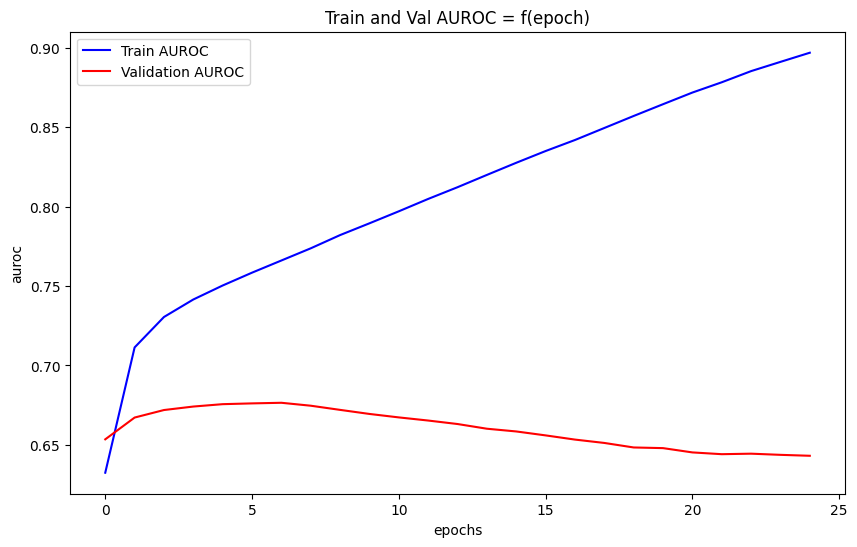

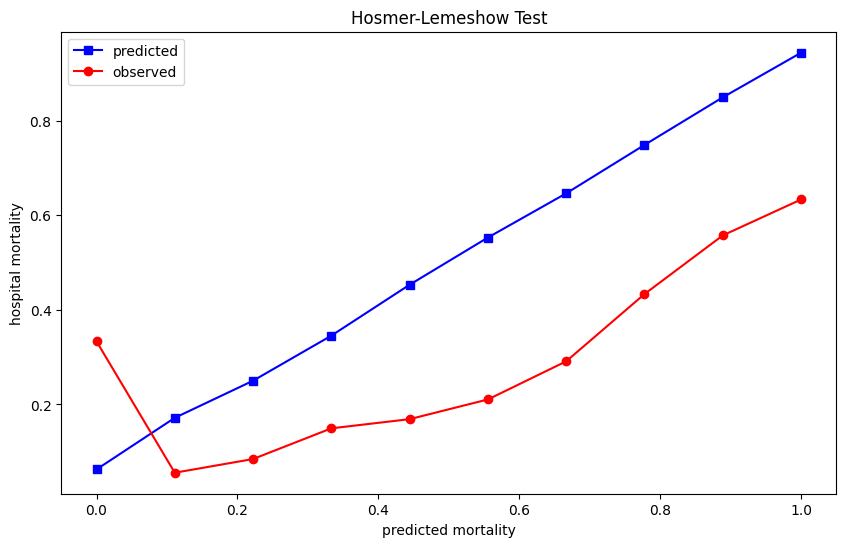


 10%|███████████████▉                                                                                                                                               | 1/10 [00:11<01:43, 11.54s/it]

test AUROC: 0.7369
test Precision: 0.3856
test Recall: 0.7662
test Specificity: 0.4751
test Accuracy: 0.6158
test F1 Score: 0.5130
test HL Score: 44.3796
Epoch 1/25, Train loss: 168.5372, Train AUROC: 0.5997
Validation Loss: 21.1463, Validation AUROC: 0.6092
Epoch 2/25, Train loss: 158.5685, Train AUROC: 0.6926
Validation Loss: 21.2472, Validation AUROC: 0.6276
Epoch 3/25, Train loss: 153.9720, Train AUROC: 0.7202
Validation Loss: 21.3068, Validation AUROC: 0.6370
Epoch 4/25, Train loss: 151.3245, Train AUROC: 0.7349
Validation Loss: 21.4423, Validation AUROC: 0.6404
Epoch 5/25, Train loss: 149.3779, Train AUROC: 0.7450
Validation Loss: 21.4366, Validation AUROC: 0.6427
Epoch 6/25, Train loss: 147.7353, Train AUROC: 0.7529
Validation Loss: 21.5045, Validation AUROC: 0.6452
Epoch 7/25, Train loss: 146.1514, Train AUROC: 0.7598
Validation Loss: 21.5869, Validation AUROC: 0.6454
Epoch 8/25, Train loss: 144.6026, Train AUROC: 0.7667
Validation Loss: 21.7055, Validation AUROC: 0.6440
Epoch 

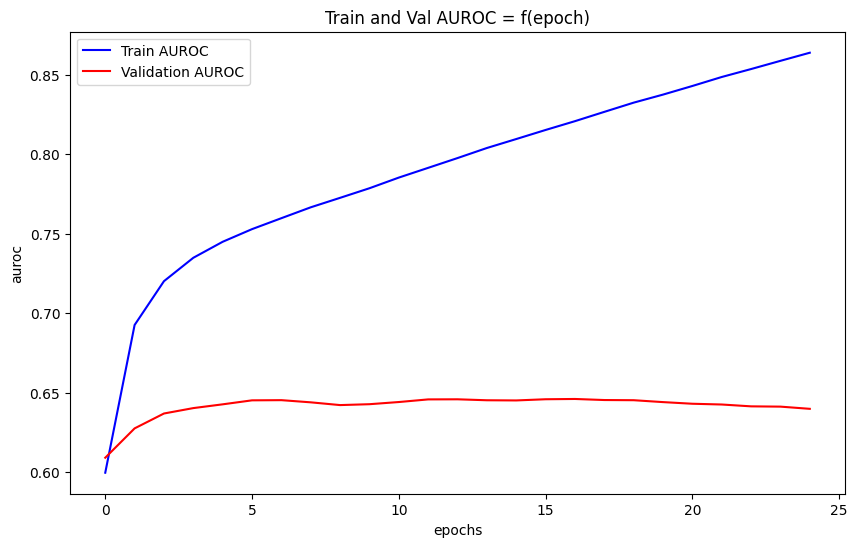

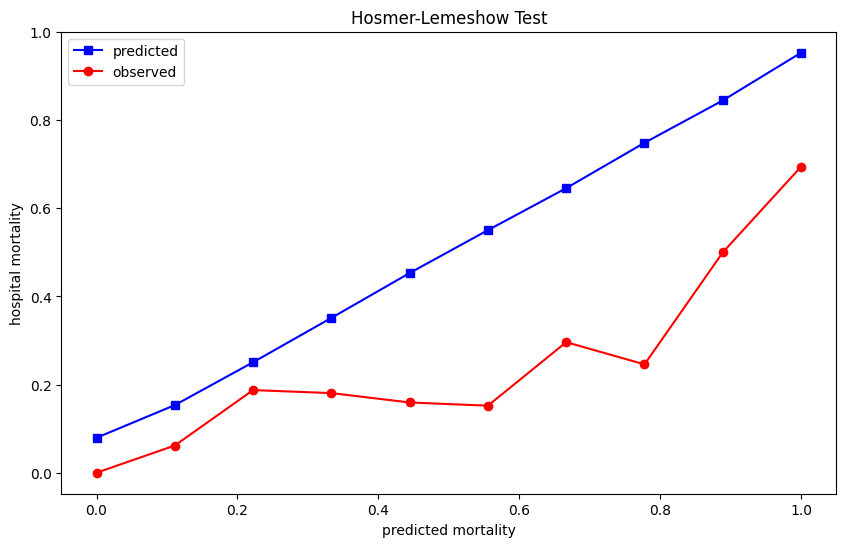


 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:23<01:32, 11.54s/it]

test AUROC: 0.7276
test Precision: 0.3527
test Recall: 0.6489
test Specificity: 0.5866
test Accuracy: 0.6535
test F1 Score: 0.4570
test HL Score: 34.3078
Epoch 1/25, Train loss: 165.7497, Train AUROC: 0.6406
Validation Loss: 19.0102, Validation AUROC: 0.7383
Epoch 2/25, Train loss: 157.5080, Train AUROC: 0.7000
Validation Loss: 18.5700, Validation AUROC: 0.7507
Epoch 3/25, Train loss: 154.2210, Train AUROC: 0.7192
Validation Loss: 18.4889, Validation AUROC: 0.7527
Epoch 4/25, Train loss: 152.1840, Train AUROC: 0.7306
Validation Loss: 18.5943, Validation AUROC: 0.7488
Epoch 5/25, Train loss: 150.5779, Train AUROC: 0.7389
Validation Loss: 18.7236, Validation AUROC: 0.7433
Epoch 6/25, Train loss: 149.1395, Train AUROC: 0.7459
Validation Loss: 18.8151, Validation AUROC: 0.7389
Epoch 7/25, Train loss: 147.7933, Train AUROC: 0.7521
Validation Loss: 18.9625, Validation AUROC: 0.7324
Epoch 8/25, Train loss: 146.5669, Train AUROC: 0.7575
Validation Loss: 19.0611, Validation AUROC: 0.7273
Epoch 

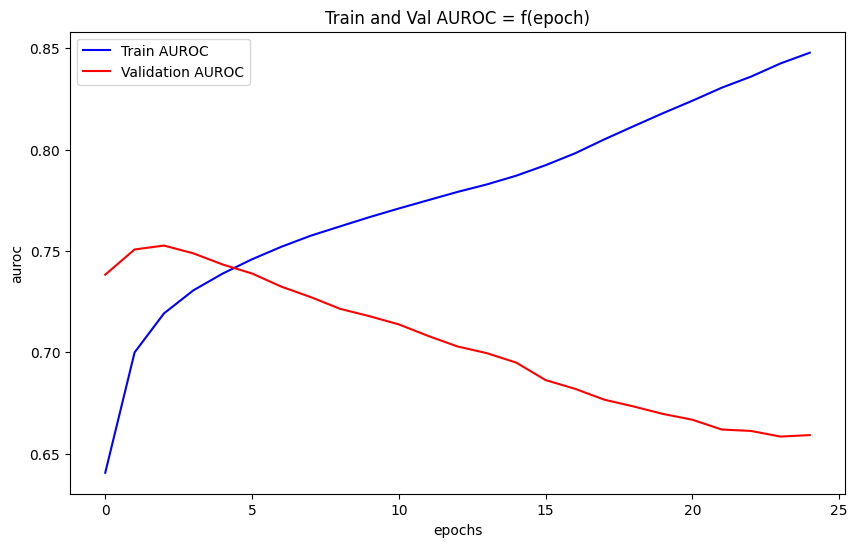

/tmp/ipykernel_34239/1933449558.py:272: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34239/1933449558.py:273: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


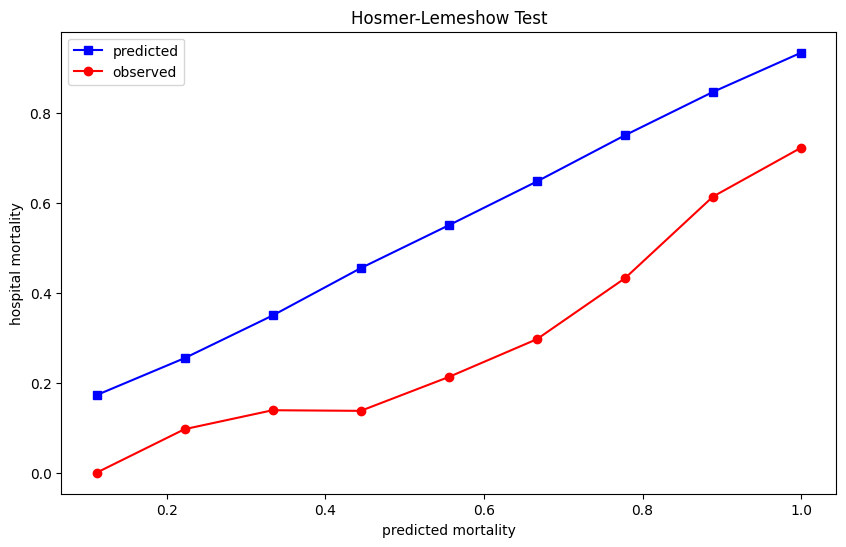

/tmp/ipykernel_34239/1933449558.py:283: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:34<01:20, 11.52s/it]

test AUROC: 0.7265
test Precision: 0.3720
test Recall: 0.7922
test Specificity: 0.4374
test Accuracy: 0.5918
test F1 Score: 0.5062
test HL Score: nan
Epoch 1/25, Train loss: 167.8640, Train AUROC: 0.6287
Validation Loss: 20.4260, Validation AUROC: 0.7130
Epoch 2/25, Train loss: 156.6223, Train AUROC: 0.7099
Validation Loss: 19.9090, Validation AUROC: 0.7242
Epoch 3/25, Train loss: 152.5190, Train AUROC: 0.7319
Validation Loss: 19.8044, Validation AUROC: 0.7254
Epoch 4/25, Train loss: 150.1164, Train AUROC: 0.7441
Validation Loss: 19.8538, Validation AUROC: 0.7229
Epoch 5/25, Train loss: 148.2223, Train AUROC: 0.7533
Validation Loss: 19.9541, Validation AUROC: 0.7199
Epoch 6/25, Train loss: 146.4052, Train AUROC: 0.7616
Validation Loss: 20.1030, Validation AUROC: 0.7154
Epoch 7/25, Train loss: 144.5220, Train AUROC: 0.7695
Validation Loss: 20.2610, Validation AUROC: 0.7113
Epoch 8/25, Train loss: 142.7640, Train AUROC: 0.7766
Validation Loss: 20.4402, Validation AUROC: 0.7081
Epoch 9/25

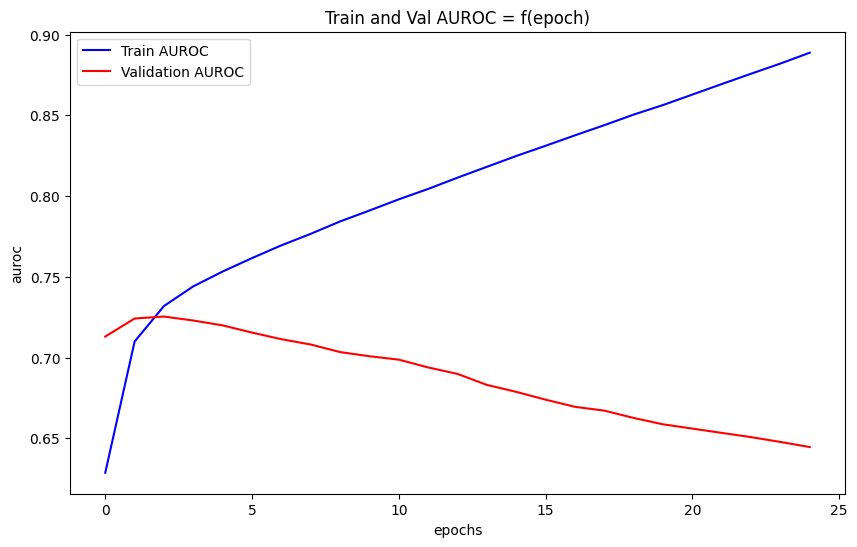

/tmp/ipykernel_34239/1933449558.py:272: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34239/1933449558.py:273: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


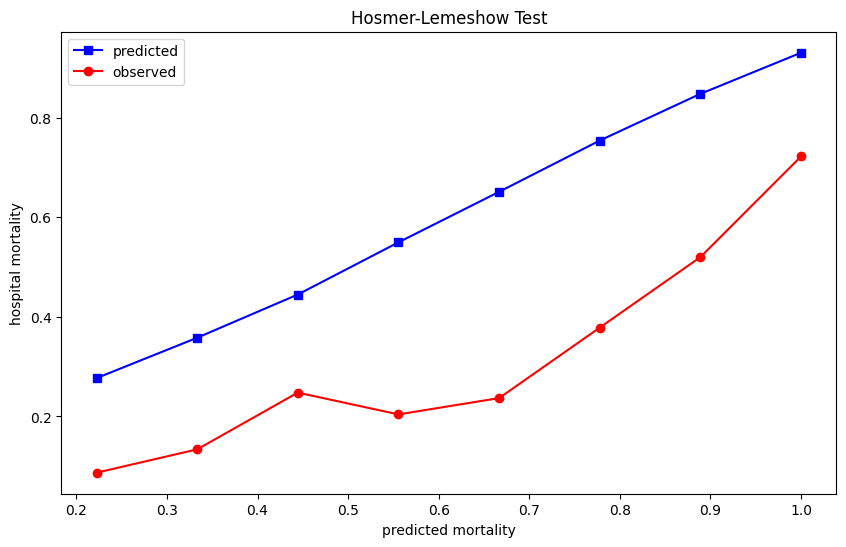

/tmp/ipykernel_34239/1933449558.py:283: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:46<01:09, 11.52s/it]

test AUROC: 0.6812
test Precision: 0.3323
test Recall: 0.6863
test Specificity: 0.4580
test Accuracy: 0.5557
test F1 Score: 0.4478
test HL Score: nan
Epoch 1/25, Train loss: 167.1641, Train AUROC: 0.6244
Validation Loss: 19.2223, Validation AUROC: 0.7469
Epoch 2/25, Train loss: 157.9879, Train AUROC: 0.6970
Validation Loss: 18.7348, Validation AUROC: 0.7617
Epoch 3/25, Train loss: 154.4874, Train AUROC: 0.7175
Validation Loss: 18.5836, Validation AUROC: 0.7615
Epoch 4/25, Train loss: 151.8657, Train AUROC: 0.7319
Validation Loss: 18.4691, Validation AUROC: 0.7588
Epoch 5/25, Train loss: 149.5523, Train AUROC: 0.7440
Validation Loss: 18.3820, Validation AUROC: 0.7552
Epoch 6/25, Train loss: 147.3818, Train AUROC: 0.7546
Validation Loss: 18.3758, Validation AUROC: 0.7517
Epoch 7/25, Train loss: 145.4999, Train AUROC: 0.7629
Validation Loss: 18.3747, Validation AUROC: 0.7501
Epoch 8/25, Train loss: 144.2160, Train AUROC: 0.7681
Validation Loss: 18.4674, Validation AUROC: 0.7454
Epoch 9/25

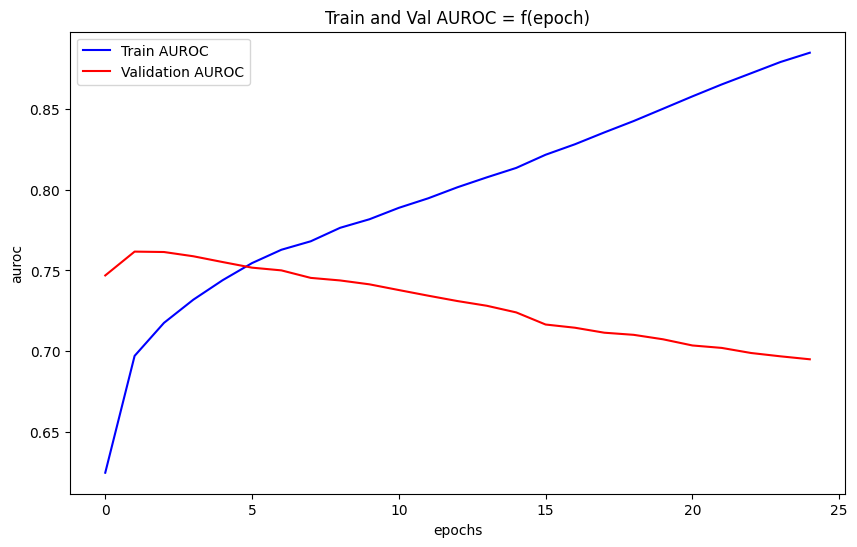

/tmp/ipykernel_34239/1933449558.py:272: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_34239/1933449558.py:273: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


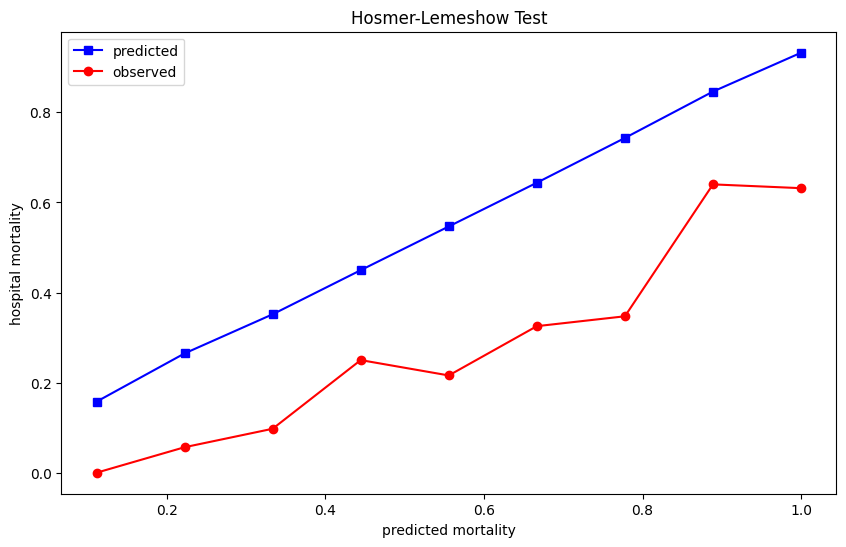

/tmp/ipykernel_34239/1933449558.py:283: RuntimeWarning: invalid value encountered in divide
  HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/HL_pred_groups*(1-HL_pred_groups/HL_num_groups))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:57<00:57, 11.52s/it]

test AUROC: 0.7300
test Precision: 0.3686
test Recall: 0.7516
test Specificity: 0.4648
test Accuracy: 0.5969
test F1 Score: 0.4946
test HL Score: nan
Epoch 1/25, Train loss: 169.0931, Train AUROC: 0.6073
Validation Loss: 20.6244, Validation AUROC: 0.7217
Epoch 2/25, Train loss: 158.2147, Train AUROC: 0.6991
Validation Loss: 19.9619, Validation AUROC: 0.7434
Epoch 3/25, Train loss: 154.7490, Train AUROC: 0.7203
Validation Loss: 19.8636, Validation AUROC: 0.7445
Epoch 4/25, Train loss: 152.8232, Train AUROC: 0.7309
Validation Loss: 19.8943, Validation AUROC: 0.7404
Epoch 5/25, Train loss: 151.1756, Train AUROC: 0.7395
Validation Loss: 19.8486, Validation AUROC: 0.7401
Epoch 6/25, Train loss: 149.8421, Train AUROC: 0.7460
Validation Loss: 19.8529, Validation AUROC: 0.7393
Epoch 7/25, Train loss: 148.5168, Train AUROC: 0.7520
Validation Loss: 19.9639, Validation AUROC: 0.7362


  0%|                                                                                                                                                                        | 0/1 [01:01<?, ?it/s]


KeyboardInterrupt: 

In [27]:
num_train = 1
K = 10

save_path = "saved_models/test.pth"
load_path = "saved_models/cnn_1d_76_76.pth"


best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_mean = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []   

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []    
    
    for j in tqdm(range(10)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, state_dict  =  train_model(data=data_MR,
                                                                                    target=target_MR,
                                                                                    test_fold = j,
                                                                                    validation_activated=True,
                                                                                    test_activated = True,
                                                                                    num_epochs=25, 
                                                                                    model_name="CNN_1D_1",
                                                                                    verbose=True, 
                                                                                    save_path=save_path, 
                                                                                    save_model=True, 
                                                                                    plot_train_curves = True,
                                                                                    load_model_path = None)
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        
        print(f"test AUROC: {auroc:.4f}")
        print(f"test Precision: {precision:.4f}")
        print(f"test Recall: {recall:.4f}")
        print(f"test Specificity: {tnr:.4f}")
        print(f"test Accuracy: {accuracy:.4f}")
        print(f"test F1 Score: {f1:.4f}")
        print(f"test HL Score: {HL_score:.4f}")
        # if best_val_auroc >= best_val_auroc_all_models:
        #     aurocs = [auroc]
        #     precisions = [precision]
        #     recalls = [recall]
        #     tnrs = [tnr]
        #     accuracies = [accuracy]
        #     f1s = [f1]
        #     best_val_auroc_all_models = best_val_auroc
        #     best_model_state_dict = state_dict
            
            # print(f"New best val_auroc: {best_val_auroc_all_models}")
    
        # print(f"Test AUROC with best model: {np.mean(aurocs):.4f}")
    
    print(f"Mean AUROC: {np.mean(aurocs):.4f}")
    print(f"Mean Precision: {np.mean(precisions):.4f}")
    print(f"Mean Recall: {np.mean(recalls):.4f}")
    print(f"Mean Specificity: {np.mean(tnrs):.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean F1 Score: {np.mean(f1s):.4f}")
    print(f"SD Auroc: {np.std(aurocs):.4f}")

    aurocs_mean.append(np.mean(aurocs))
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_mean):.4f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.4f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.4f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.4f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.4f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.4f}")

In [ ]:
a = 0.4908
b = 0.5192
print(2/3 * a + 1/3 * b)

In [ ]:
# window_time_days = 5
# target_ECMO_test, id_list_ECMO_test = prepareDeathList("dataECMO", window_time_days)
# data_ECMO_test = prepareData("dataECMO", id_list_ECMO_test, window_time_days)
# print(f"dataset size: {len(target_ECMO_test)} , num_deceased: {np.sum(target_ECMO_test)}")

In [ ]:
num_features = np.size(data_ECMO,2)
num_features_dynamic = 9
num_features_static = 3

input_size = 1
hidden_size = 16
num_layers = 2
output_size = 1

# model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)
model = CNN_1D_1(num_features)

save_path = "./saved_models/test.pth"
model_state_dict = torch.load(save_path)
model.load_state_dict(model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels = []
predictions = []
predictions_binary = []

treshold = 0.5

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        true_labels.extend(labels.numpy())

        outputs = nn.functional.sigmoid(model(inputs))
        predictions.extend(outputs.numpy())
        predictions_binary.extend((outputs.numpy() > treshold).astype(int))
        
        # print(np.round(np.array([p[0] for p in outputs.numpy()]), 1))
        # print(np.round(np.array(labels), 1))

auroc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary, zero_division=0)
accuracy = accuracy_score(true_labels, predictions_binary)

print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {tnr:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
from sktime.classification.deep_learning import InceptionTimeClassifier
import keras

aurocs = []
precisions = []
recalls = []
tnrs = []
accuracies = []
f1s = []

test_activated = True
validation_activated = False

data = data_MR
target = target_MR

K = 10
for j in range(K):
    num_samples = len(target)

    sub_samples_size = num_samples//K

    test_fold = j
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,K-1)
        while val_fold == test_fold:
            val_fold = random.randint(0,K-1)
    else:
        val_fold = None
    
    x_train = np.empty((0,np.shape(data)[1], np.shape(data)[2]))
    y_train = []
    x_test = []
    y_test = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            x_train = np.concatenate((x_train, current_data_fold))
            y_train = y_train + current_target_fold

    num_samples = len(target)
    num_timesteps = 24 * 5
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static



    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)

    
    clf = InceptionTimeClassifier(batch_size=64,
                                  metrics = [keras.metrics.AUC()], 
                                  verbose=True, 
                                  n_epochs=1,
                                  n_filters=32,
                                  depth=6,
                                  kernel_size=20, 
                                  bottleneck_size=32)  

    clf.fit(x_train, np.array(y_train))
    
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
    y_pred = clf.predict(x_test)
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    aurocs.append(auroc)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    f1s.append(f1)
    accuracies.append(accuracy)

    print(f"AUROC: {auroc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"tnr: {tnr:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate and print the mean scores
print(f"AUROC: {np.mean(aurocs):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"tnr: {np.mean(tnrs):.4f}")
print(f"Accuracy: {np.mean(accuracy):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

In [ ]:
precisions_seuil = []
recalls_seuil = []
tnrs_seuil = []
accuracies_seuil = []
f1s_seuil = []

seuils = [s/100 for s in range(0,100)]

for seuil in seuils:
        
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
        
    y_pred = (y_pred_proba > seuil).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    tnr = tnr_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    
    precisions_seuil.append(precision)
    recalls_seuil.append(recall)
    tnrs_seuil.append(tnr)
    accuracies_seuil.append(accuracy)
    f1s_seuil.append(f1)


plt.figure(figsize=(10, 6))

plt.plot(seuils, precisions_seuil, label='precision', color='blue')
plt.plot(seuils, recalls_seuil, label='recall', color='green')
plt.plot(seuils, tnrs_seuil, label='specificity', color='yellow')
plt.plot(seuils, accuracies_seuil, label='accuracy', color='red')
plt.plot(seuils, f1s_seuil, label='f1-score', color='purple')

plt.xlabel('seuil')
plt.ylabel('metrics values')
plt.title('Metrics values = f(seuil)')

plt.legend()

plt.show()